In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter_ns

In [2]:
def kde_scipy(x, x_grid, bandwidth_method=0.075, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.

    kde = gaussian_kde(x.T, bw_method=bandwidth_method, **kwargs)
    return kde.evaluate(x_grid.T)

def kde_scipy_log(*args, **kwargs):
    return np.log(kde_scipy(*args, **kwargs))

def kde_sklearn_log(x, x_grid, bandwidth=0.075, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid)
    return log_pdf

def kde_sklearn(*args, **kwargs):
    return np.exp(kde_sklearn_log(*args, **kwargs))

kde_funcs = [kde_scipy, kde_sklearn]
kde_funcnames = ['Scipy', 'Scikit-learn']

In [3]:
def time_func(func, *args, **kwargs):
    """Returns the execution time for func in milliseconds."""
    
    t1 = perf_counter_ns()
    func(*args, **kwargs)
    t2 = perf_counter_ns()
    return (t2 - t1) / 1e6

In [4]:
dataframe = pd.read_csv('GW151226_post.dat', sep='\t')
dataframe.drop(columns=['Mc', 'Mt', 'q'], inplace=True)
dataframe.columns

Index(['m1', 'm2', 'z', 'chieff'], dtype='object')

In [5]:
data = dataframe.to_numpy()
print(data.shape)

(52252, 4)


In [6]:
import optuna 

def objective(kde):

    def objective_skl(trial):

        bw = trial.suggest_loguniform('bw', low=1e-3, high=1)
        N = trial.suggest_int('N', low=100, high=len(data), log=True)

        t1 = perf_counter_ns()
        loglik = kde(data[:N:2], data[1:N:2], bw)
        t2 = perf_counter_ns()
        return np.log10((t2 - t1) / 1e6), np.average(loglik)

    return objective_skl

In [19]:
study_skl = optuna.create_study(directions=['minimize', 'maximize'])
study_skl.optimize(objective(kde_sklearn_log), timeout=60*30)

study_scipy = optuna.create_study(directions=['minimize', 'maximize'])
study_scipy.optimize(objective(kde_scipy_log), timeout=60*30)


4] Trial 1021 finished with values: [3.9017189115426514, 2.5116107610685874] and parameters: {'bw': 0.10238350660302585, 'N': 36279}. 
[I 2021-11-19 18:50:23,434] Trial 1022 finished with values: [1.5708171242876803, 1.8987308048519709] and parameters: {'bw': 0.19202400768245909, 'N': 2522}. 
[I 2021-11-19 18:50:23,440] Trial 1023 finished with values: [0.25301313239209217, -inf] and parameters: {'bw': 0.0019767870329065952, 'N': 395}. 
[I 2021-11-19 18:50:33,787] Trial 1024 finished with values: [4.0142919958453716, -inf] and parameters: {'bw': 0.007073179440499842, 'N': 45068}. 
[I 2021-11-19 18:50:34,539] Trial 1025 finished with values: [2.872910978884956, -inf] and parameters: {'bw': 0.0014327009981779835, 'N': 12126}. 
[I 2021-11-19 18:50:34,789] Trial 1026 finished with values: [2.39057951271685, 1.3220769243482857] and parameters: {'bw': 0.4517496625962116, 'N': 7037}. 
[I 2021-11-19 18:50:34,799] Trial 1027 finished with values: [0.620101164207398, -3.5467998098174673] and par

In [20]:
from optuna.visualization import *

plot_pareto_front(study_skl)

In [11]:
plot_pareto_front(study_scipy)

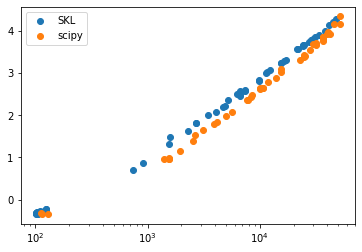

In [32]:
def plot_time_vs_N(study, name):
    bws = [trial.params['bw'] for trial in study.best_trials]
    Ns = [trial.params['N'] for trial in study.best_trials]
    times = [trial.values[0] for trial in study.best_trials]

    plt.scatter(Ns, times, label=name)
    plt.xscale('log')

def plot_bw_vs_N(study, name):
    bws = [trial.params['bw'] for trial in study.best_trials]
    Ns = [trial.params['N'] for trial in study.best_trials]
    times = [trial.values[0] for trial in study.best_trials]

    plt.scatter(Ns, bws, label=name)
    plt.xscale('log')

def plot_accuracy_vs_N(study, name):
    bws = [trial.params['bw'] for trial in study.best_trials]
    Ns = [trial.params['N'] for trial in study.best_trials]
    times = [trial.values[0] for trial in study.best_trials]
    logliks = [trial.values[1] for trial in study.best_trials]

    plt.scatter(Ns, logliks, label=name)
    plt.xscale('log')

def plot_accuracy_vs_time(study, name):
    times = [trial.values[0] for trial in study.best_trials]
    logliks = [trial.values[1] for trial in study.best_trials]

    plt.scatter(times, logliks, label=name)

plot_time_vs_N(study_skl, 'SKL')
plot_time_vs_N(study_scipy, 'scipy')
plt.legend()

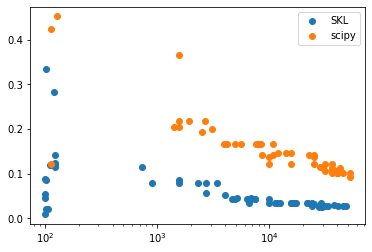

In [27]:
plot_bw_vs_N(study_skl, 'SKL')
plot_bw_vs_N(study_scipy, 'scipy')
plt.legend()

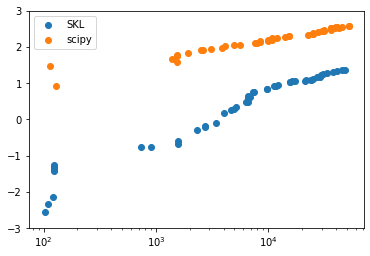

In [31]:
plot_accuracy_vs_N(study_skl, 'SKL')
plot_accuracy_vs_N(study_scipy, 'scipy')
plt.ylim(-3, 3)
plt.legend()

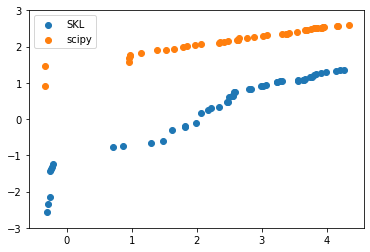

In [34]:
plot_accuracy_vs_time(study_skl, 'SKL')
plot_accuracy_vs_time(study_scipy, 'scipy')
plt.ylim(-3, 3)
plt.legend()

In [11]:
Ns = np.geomspace(100, len(data)//5, num=20, dtype=int)
ts_scipy = []
ts_skl = []

for N in Ns:
    t_scipy = time_func(kde_scipy, data[:N:2], data[1:N:2])
    t_skl = time_func(kde_scipy, data[:N:2], data[1:N:2])
    ts_scipy.append(t_scipy)
    ts_skl.append(t_skl)
    print(f'Time for {N//2} evaluations: {t_scipy:.2f}ms for scipy, {t_skl:.2f}ms for skl')
# gaussian_kde(data[:1000:2].T)
# np.linalg.cholesky(np.cov(data[:1000:2].T))

Time for 50 evaluations: 1.28ms for scipy, 0.98ms for skl
Time for 63 evaluations: 0.79ms for scipy, 0.67ms for skl
Time for 81 evaluations: 0.83ms for scipy, 0.79ms for skl
Time for 104 evaluations: 0.93ms for scipy, 0.91ms for skl
Time for 133 evaluations: 1.27ms for scipy, 1.25ms for skl
Time for 169 evaluations: 1.71ms for scipy, 1.73ms for skl
Time for 217 evaluations: 2.25ms for scipy, 2.00ms for skl
Time for 277 evaluations: 4.05ms for scipy, 4.16ms for skl
Time for 354 evaluations: 5.05ms for scipy, 4.35ms for skl
Time for 452 evaluations: 6.94ms for scipy, 6.87ms for skl
Time for 577 evaluations: 10.08ms for scipy, 9.72ms for skl
Time for 737 evaluations: 15.88ms for scipy, 16.84ms for skl
Time for 942 evaluations: 27.20ms for scipy, 26.11ms for skl
Time for 1203 evaluations: 41.37ms for scipy, 51.80ms for skl
Time for 1537 evaluations: 85.01ms for scipy, 79.60ms for skl
Time for 1963 evaluations: 130.48ms for scipy, 131.66ms for skl
Time for 2507 evaluations: 207.04ms for sci

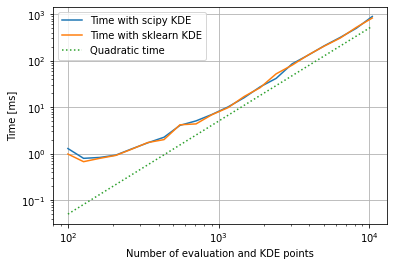

In [12]:
plt.loglog(Ns, ts_scipy, label='Time with scipy KDE')
plt.loglog(Ns, ts_skl, label='Time with sklearn KDE')
plt.loglog(Ns, Ns**2/2e5, ls=':', label='Quadratic time')
plt.ylabel('Time [ms]')
plt.xlabel('Number of evaluation and KDE points')
plt.legend()
plt.grid('on')

52252